# <div class="alert alert-info" style="text-align: center;" markdown="1">Statistical Experiments and Significance Testing</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## `A/B Testing`

- A/B testing is a method used to compare the performance of two versions of a web page or app against each other to determine which one performs better.
- A/B testing is a form of hypothesis testing, where two hypotheses are compared against each other.
- The null hypothesis is that there is no difference between the two versions, while the alternative hypothesis is that there is a difference between the two versions.
- The goal of A/B testing is to determine if the difference between the two versions is statistically significant.


## `Hypothesis Testing`

- Hypothesis testing is a method used to determine if there is a significant difference between two groups.
- The null hypothesis is the default assumption that there is no difference between the two groups.
- The alternative hypothesis is the hypothesis that there is a difference between the two groups.

#### One-Way Test

- A one-way test is used to determine if there is a significant difference between two groups in one direction.

#### Two-Way Test

- A two-way test is used to determine if there is a significant difference between two groups in either direction.

### Resampling

- Resampling is a method used to estimate the distribution of a statistic by repeatedly sampling from the data.
- Resampling methods include bootstrapping and permutation testing.

#### Bootstrapping

- Bootstrapping is a method used to estimate the distribution of a statistic by resampling with replacement from the data.
- Bootstrapping is used to estimate the standard error of a statistic and to construct confidence intervals.

#### Permutation Testing

- Permutation testing is a method used to determine if there is a significant difference between two groups by permuting the data and calculating the test statistic.
- Permutation testing is used to estimate the p-value of a hypothesis test.

### Website Sessions Example

In [2]:
df_website = pd.read_csv('data/web_page_data.csv')
df_website.head()

,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


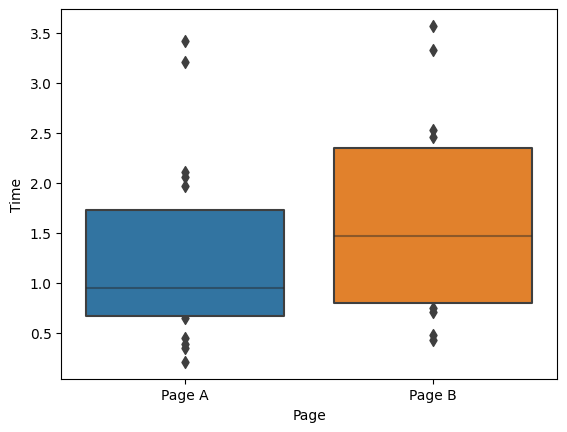

In [3]:
fig, ax = plt.subplots()

sns.boxenplot(x='Page', y='Time', data=df_website, ax=ax)
plt.show()

In [4]:
mean_A = df_website[df_website['Page'] == 'Page A']['Time'].mean()
mean_B = df_website[df_website['Page'] == 'Page B']['Time'].mean()
mean_A, mean_B

(1.2633333333333332, 1.62)

In [5]:
mean_B - mean_A

0.3566666666666669

❔ Is this difference in the number of sessions between the two versions statistically significant?

In [6]:
df_website["Page"].value_counts()

Page A    21
Page B    15
Name: Page, dtype: int64

In [7]:
def perm_func(x, nA, nB):
    n = nA + nB
    idx_B = np.random.choice(range(n), nB)
    idx_A = np.setdiff1d(range(n), idx_B)
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

In [8]:
perm_diffs = [perm_func(df_website['Time'], df_website[df_website["Page"] == "Page A"].shape[0], df_website[df_website["Page"] == "Page B"].shape[0]) for _ in range(1000)]

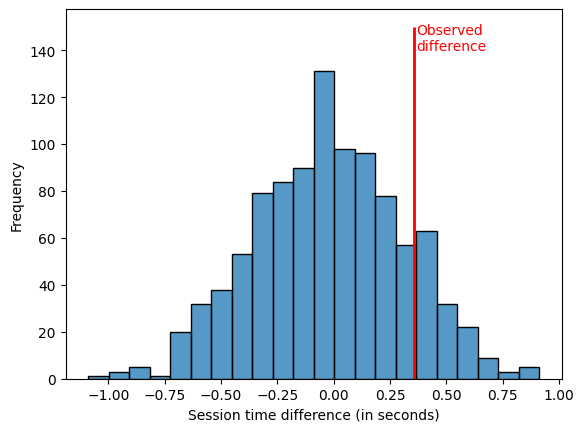

In [9]:
fig, ax = plt.subplots()

sns.histplot(perm_diffs, ax=ax)
ax.vlines([mean_B - mean_A], color='red', ymin=0, ymax=150, lw=2)
ax.text(mean_B - mean_A + 0.01, 140, 'Observed\ndifference', color='red')
ax.set_xlabel('Session time difference (in seconds)')
ax.set_ylabel('Frequency')
plt.show()

In [10]:
np.mean(perm_diffs > mean_B - mean_A)

0.135

## `Statistical Significance and P-Values`

> Example- Conversion Rate

In [11]:
observed_pct_diff = 100 * (200/23739 - 182/22588)
print(f'Observed difference: {observed_pct_diff:.4f}%')

Observed difference: 0.0368%


In [12]:
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

In [13]:
perm_diff_conv = [100 * perm_func(conversion, 23739, 22588) for _ in range(1000)]

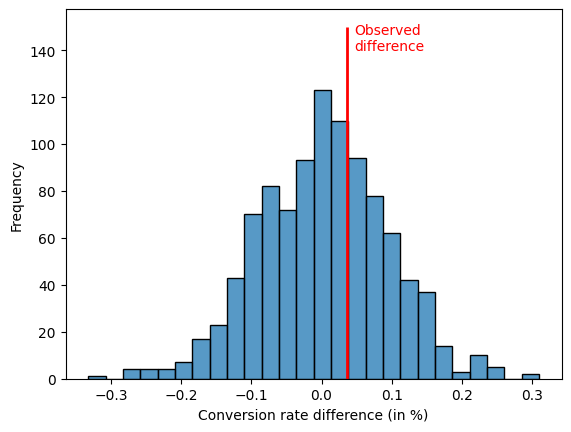

In [14]:
fig, ax = plt.subplots()

sns.histplot(perm_diff_conv, ax=ax)
ax.vlines([observed_pct_diff], color='red', ymin=0, ymax=150, lw=2)
ax.text(observed_pct_diff + 0.01, 140, 'Observed\ndifference', color='red')
ax.set_xlabel('Conversion rate difference (in %)')
ax.set_ylabel('Frequency')
plt.show()

😱 From graph it is hard to measure statistical significance. So we use p-value. 

In [15]:
np.mean([perm_diff > observed_pct_diff for perm_diff in perm_diff_conv])

0.353

> Without permutation testing, we can find p-value by using scipy.stats.chi2_contingency

In [16]:
from scipy import stats


conversions = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p, df, _ = stats.chi2_contingency(conversions)

In [17]:
conversions

array([[  200, 23539],
       [  182, 22406]])

In [18]:
print(f'Chi-square: {chi2:.4f}')
print(f'p-value: {p/2:.4f}')
print(f'Degrees of freedom: {df}')

Chi-square: 0.1489
p-value: 0.3498
Degrees of freedom: 1


## `T-Test`

- A t-test is a method used to determine if there is a significant difference between the means of two groups.

#### Formula

- t = (x̄1 - x̄2) / √(s1^2/n1 + s2^2/n2)

- df = n1 + n2 - 2

- p-value = 2 * (1 - t.cdf(abs(t), df))

#### Example

- x̄1 = 10, s1 = 2, n1 = 100

- x̄2 = 12, s2 = 3, n2 = 100

- t = (10 - 12) / √(2^2/100 + 3^2/100) = -2 / √(0.04 + 0.09) = -2 / √0.13 = -2 / 0.36 = -5.56

- df = 100 + 100 - 2 = 198

- p-value = 2 * (1 - t.cdf(abs(-5.56), 198)) = 2 * (1 - t.cdf(5.56, 198)) = 2 * (1 - 0.9999999999999999) = 2 * 0.0 = 0.0

#### Conclusion

- The p-value is less than 0.05, so we reject the null hypothesis and conclude that there is a significant difference between the means of the two groups.


In [19]:
from scipy.stats import ttest_ind

res = ttest_ind(df_website[df_website['Page'] == 'Page A']['Time'], df_website[df_website['Page'] == 'Page B']['Time'], equal_var=False)

print(f'T-statistic: {res.statistic:.4f}')
print(f'p-value: {res.pvalue/2:.4f}')

T-statistic: -1.0983
p-value: 0.1408


## `ANOVA - Analysis of Variance`

- ANOVA is a method used to determine if there is a significant difference between the means of three or more groups.


#### Algorithm

- Combine all the data into a single dataset.
- Shuffle and draw samples from the combined dataset to create new datasets for each group.
- Calculate the mean of each group.
- Calculate the varriance among the means of the groups.
- Repeat the process many times to estimate the distribution of the variance.



In [20]:
df_4_sessions = pd.read_csv('data/four_sessions.csv')
df_4_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [21]:
# df_4_sessions = df_4_sessions.pivot(columns='Page', values='Time').fillna(0)

In [22]:
# df_4_sessions.head()

In [23]:
observed_var = df_4_sessions.groupby("Page").mean().var()[0]
observed_var

55.426666666666655

In [24]:
print("Observed mean: ", df_4_sessions.groupby("Page").mean().values.ravel())
print("Observed variance: ", observed_var)

Observed mean:  [172.8 182.6 175.6 164.6]
Observed variance:  55.426666666666655


In [25]:
def perm_test(df):
    df = df.copy()
    df["Time"] = np.random.permutation(df["Time"].values)
    return df.groupby("Page").mean().var()[0]

In [26]:
perm_var = [perm_test(df_4_sessions) for _ in range(3000)]
print(f"Pr(Prob): {100*np.mean([var > observed_var for var in perm_var])}%")

Pr(Prob): 8.233333333333333%


### F-Statisitc

- The F-statistic is a measure of the ratio of the variance between groups to the variance within groups.

- The F-statistic is used to determine if there is a significant difference between the means of the groups.

- The F-statistic is calculated as the ratio of the variance between groups to the variance within groups.


- F = (SSB / (k - 1)) / (SSW / (n - k))

- df1 = k - 1

- df2 = n - k

- p-value = 1 - f.cdf(F, df1, df2)


In [27]:


import statsmodels.formula.api as smf

model = smf.ols('Time ~ Page', data=df_4_sessions).fit()
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     2.740
Date:                Fri, 19 Jul 2024   Prob (F-statistic):             0.0776
Time:                        22:24:46   Log-Likelihood:                -72.313
No. Observations:                  20   AIC:                             152.6
Df Residuals:                      16   BIC:                             156.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        172.8000      4.498     38.419      0.000     163.265     182.335
Page[T.Page 2]     9.8000      6.361      1.541      0.143      -3.684      23.284
Page[T.Page 3]     2.8000      6.361      0.440      0.666     -10.684      16.284
Page[T.Page 4]    -8.2000      6.361     -1.289      0.216     -21.684       5.284
==============================================================================
Omnibus:                        2.928   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                1.345
Skew:                           0.578   Prob(JB):                        0.510
Kurtosis:                       3.529   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
import statsmodels.api as sm

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


## `Chi-Square Test`

- The chi-square test is a method used to determine if there is a significant association between two categorical variables.


- χ^2 = Σ((O - E)^2 / E)

- df = (r - 1) * (c - 1)

- p-value = 1 - chi2.cdf(χ^2, df)

### Chi-Square Test: Resampling Approach

- The resampling approach to the chi-square test involves permuting the data and calculating the test statistic many times to estimate the p-value.

- Constitute a box with 34 ones (clicks) and 2966 zeros (non-clicks).
- Shuffle the box and draw samples of 1000 and count the cliks in each.
- Find the squared difference between the observed and expected values and sum them.
- Repeat the process many times to estimate the distribution of the test statistic.
- How often does the resampled test statistic exceed the observed test statistic?

In [32]:
df_clicks = pd.read_csv("data/click_rates.csv")
df_clicks

,Headline,Click,Rate
0,Headline A,Click,14
1,Headline A,No-click,986
2,Headline B,Click,8
3,Headline B,No-click,992
4,Headline C,Click,12
5,Headline C,No-click,988


In [29]:
import random


box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)



In [30]:
def chi2_test(observerd, expected):
    pearson_residuals = []
    for row, expect in zip(observerd, expected):
            pearson_residuals.append([(obs - expect) ** 2 / expect for obs in row])

    return np.sum(pearson_residuals)

In [43]:
expected_clicks = 34/3
expected_non_clicks = 1000 - expected_clicks
expected = [34/3, 1000-34/3]
chi2_observed = chi2_test([df_clicks[df_clicks["Click"] == "Click"]["Rate"].values], expected)

In [44]:
chi2_observed

1.6470588235294115

In [45]:
def perm_func(box):
    sample_clicks = [sum(random.sample(box,1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2_test([sample_clicks, sample_noclicks], expected)

In [47]:
perm_chi2_2 = [perm_func(box) for _ in range(2000)]

In [48]:
resampled_p_value = sum(perm_chi2_2 > chi2_observed)/len(perm_chi2_2)
print("Observed Chi2: ", chi2_observed)
print("Resampled p-value: ", resampled_p_value)

Observed Chi2:  1.6470588235294115
Resampled p-value:  0.491


### Chi-Squre Tests: Statistical Theory



In [59]:
from scipy.stats import chi2_contingency

chi2, pvalue, df, expected = chi2_contingency(df_clicks["Rate"])

In [60]:
chi2, pvalue, df, expected

(0.0, 1.0, 0, array([ 14., 986.,   8., 992.,  12., 988.]))

### Fisher's Exact Test

- All possible permutations possible.

## `Multi-Arm Bandit Algorithms`



## `Power and Sample Size`

In [75]:
import statsmodels as sm

effect_size = sm.stats.proportion.proportion_effectsize(0.0121, 0.011)
ananlysis = sm.stats.power.TTestIndPower()
result = ananlysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8, alternative='larger')

In [76]:
result

116602.39259746042